In [1]:
cd t:\freely_moving_ephys\ephys_recordings\101520\G6H28P6LT\fm1

t:\freely_moving_ephys\ephys_recordings\101520\G6H28P6LT\fm1


In [2]:
#cd \\niell-v2-w7\freely_moving_ephys\ephys_recordings\092820\J524RT\outputs_Oct07a


In [3]:
ls

 Volume in drive T is 8tb internal A
 Volume Serial Number is 7481-8BF5

 Directory of t:\freely_moving_ephys\ephys_recordings\101520\G6H28P6LT\fm1

11/14/2020  01:06 PM    <DIR>          .
11/14/2020  01:06 PM    <DIR>          ..
10/15/2020  12:46 PM    <DIR>          .phy
11/04/2020  12:16 PM    <DIR>          101520_fm1_eye_world
11/04/2020  12:34 PM     3,828,883,851 101520_fm1_eye_world.zip
10/29/2020  11:13 AM           969,848 101520_fm1_world_spikes.mp4
10/15/2020  10:24 AM     2,435,055,616 101520_G6H28P6LT_fm1_Ephys.bin
10/28/2020  09:32 AM           877,357 101520_G6H28P6LT_fm1_ephys.json
10/15/2020  10:24 AM         2,823,832 101520_G6H28P6LT_fm1_Ephys_BonsaiTS.csv
10/15/2020  12:11 PM     1,217,527,808 101520_G6H28P6LT_fm1_Ephys_int16_med1_nch16.bin
11/07/2020  08:56 AM        85,477,529 101520_G6H28P6LT_fm1_Ephys_medianTrace.mat
11/14/2020  12:18 PM         1,064,307 101520_G6H28P6LT_fm1_ephys_merge.json
10/15/2020  10:24 AM       338,358,316 101520_G6H28P6LT_fm1_REYE.av

In [4]:
world_file = r'092820_J524RT_fm1world.nc'
eye_file = '092820_J524RT_fm1Reye.nc'
ephys_file = '092820_J524RT_fm1_ephys.json'
top_file = '092820_J524RT_fm1_TOP1.nc'

eye_file =   "101520_G6H28P6LT_fm1Reye.nc"
world_file = '101520_G6H28P6LT_fm1world.nc'
ephys_file = '101520_G6H28P6LT_fm1_ephys_merge.json'
top_file = '101520_G6H28P6LT_fm1_TOP1.nc'




In [5]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pickle
import time
from matplotlib.animation import FFMpegWriter
import matplotlib as mpl 
import wavio
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Program Files\ffmpeg\bin\ffmpeg.exe'
from scipy.interpolate import interp1d
from numpy import nan

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [6]:
top_data = xr.open_dataset(top_file)
top_vid = np.uint8(top_data['TOP1_video'])
top_data

<xarray.Dataset>
Dimensions:     (frame: 76059, height: 270, point_loc: 33, width: 360)
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 76054 76055 76056 76057 76058
  * point_loc   (point_loc) object 'nose_x' ... 'base_implant_likelihood'
    timestamps  (frame) float64 ...
    trial       object ...
Dimensions without coordinates: height, width
Data variables:
    TOP1_pts    (point_loc, frame) float64 ...
    TOP1_video  (frame, height, width) int8

In [7]:
top_vid = np.uint8(top_data['TOP1_video'])
topT = top_data['timestamps']
topT

<xarray.DataArray 'timestamps' (frame: 76059)>
array([39819.920755, 39819.937305, 39819.95392 , ..., 41087.938688,
       41087.955596, 41087.966348])
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 76054 76055 76056 76057 76058
    timestamps  (frame) float64 3.982e+04 3.982e+04 ... 4.109e+04 4.109e+04
    trial       <U25 '101520_G6H28P6LT_fm1_TOP1'

(0.0, 5.0)

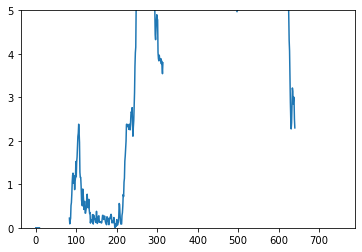

In [144]:
# get points from top cam to calculate locomotion
# base of spine seems most reliable
ptNames = top_data['TOP1_pts']
spinex = ptNames.sel(point_loc = 'spine_x').copy()
spiney = ptNames.sel(point_loc = 'spine_y').copy()
spinep = ptNames.sel(point_loc = 'spine_likelihood').copy()

#smooth pts before calculating speed
box = np.ones(31)/31
spinex_sm = np.convolve(spinex, box, mode='same')
spiney_sm = np.convolve(spiney,box,mode = 'same')

#speed
spd = np.sqrt(np.diff(spinex_sm)**2 + np.diff(spiney_sm)**2)*60/10
spd[0:10]=0
plt.plot(spd[0:1800])


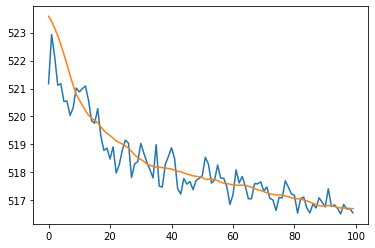

In [143]:
plt.plot(spinex[100:200])
plt.plot(spinex_sm[100:200])

In [9]:
# load worldcam
world_data = xr.open_dataset(world_file)
world_vid_raw = np.uint8(world_data['WORLD_video'])



In [10]:
#resize worldcam to make more manageable
sz = world_vid_raw.shape
downsamp = 0.25
world_vid = np.zeros((sz[0],np.int(sz[1]*downsamp),np.int(sz[2]*downsamp)), dtype = 'uint8')
for f in range(sz[0]):
    world_vid[f,:,:] = cv2.resize(world_vid_raw[f,:,:],(np.int(sz[2]*downsamp),np.int(sz[1]*downsamp)))
worldT = world_data.timestamps.copy()
world_data

<xarray.Dataset>
Dimensions:      (frame: 68481, height: 240, width: 320)
Coordinates:
  * frame        (frame) int64 0 1 2 3 4 5 ... 68476 68477 68478 68479 68480
    timestamps   (frame) float64 ...
Dimensions without coordinates: height, width
Data variables:
    WORLD_times  (frame) float64 ...
    WORLD_video  (frame, height, width) int8 20 -100 103 110 114 ... 43 42 42 42

Text(0.5, 0, 'deltaT')

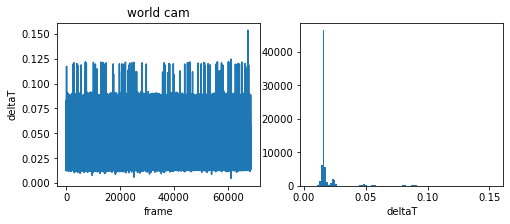

In [11]:
# plot worldcam timing
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(worldT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('world cam')
axs[1].hist(np.diff(worldT),100);axs[1].set_xlabel('deltaT')

Text(0.5, 1.0, 'mean worldcam')

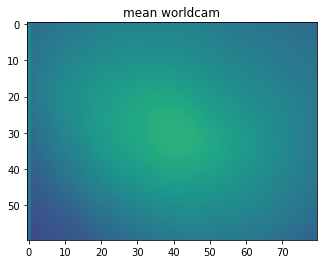

In [12]:
# plot mean world image
plt.imshow(np.mean(world_vid,axis=0),vmin=0,vmax=255); plt.title('mean worldcam')

In [13]:
# read ephys data
ephys_data = pd.read_json(ephys_file)
ephys_data


,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,waveform,spikeT,t0
0,392.0,19.8,mua,27.890654,0,1,6.634466,good,12812,0,"[0.0033347560000000004, 0.0074715107000000005,...","[0.1515, 0.21030000000000001, 0.3078, 0.5303, ...",39819.652083
1,559.6,780.0,mua,25.195724,0,1,0.035213,noise,68,0,"[-0.009456127, -0.011458151000000001, -0.01270...","[15.5203666667, 40.4977, 49.1922666667, 49.655...",39819.652083
2,1338.4,311.9,mua,23.496183,0,1,0.012946,noise,25,0,"[-0.0045733261, -0.007256208, -0.0097557865, -...","[40.4982, 247.5415, 253.1051, 255.4794333333, ...",39819.652083
3,288.3,152.2,mua,23.235289,1,2,2.211144,noise,4270,0,"[0.012037983200000001, -0.008592386700000001, ...","[0.8459666667, 0.8578333333, 0.8597333333, 0.8...",39819.652083
4,237.8,157.2,mua,17.656380,9,10,0.924330,noise,1785,0,"[-0.017415067200000002, -0.0170937255, -0.0244...","[3.0782333333, 3.0884666667, 3.0889333333, 3.0...",39819.652083
5,539.1,334.7,mua,23.930361,1,2,0.063693,noise,123,0,"[0.0034972217000000002, -0.0161124803, -0.0147...","[31.6818666667, 40.3679333333, 53.3543333333, ...",39819.652083
6,397.2,8.8,good,25.888235,2,3,3.971773,good,7670,0,"[0.0074969623, 0.0077951048, 0.0082895886, 0.0...","[0.1880666667, 0.2228, 0.8604, 0.9527333333, 1...",39819.652083
7,380.0,38.4,mua,28.836113,2,3,1.649296,noise,3185,0,"[0.0160707124, 0.0009992011, 0.0051890896, 0.0...","[0.868, 1.2370333333, 5.9868333333, 6.0325, 6....",39819.652083
8,437.3,0.0,mua,30.644802,2,3,0.167260,noise,323,0,"[-0.0015187341000000001, -0.006412589900000000...","[4.7244, 26.1585666667, 26.4261, 28.6274666667...",39819.652083
9,565.4,2340.0,mua,31.796846,2,3,0.037802,noise,73,0,"[0.0181639921, 0.007102252000000001, 0.0120978...","[16.7068, 58.3828333333, 94.0868, 96.8853, 96....",39819.652083


In [14]:
# get intitial ephys timepoint (t0)
ephysT0 = ephys_data.iloc[0,12]
ephysT0 

39819.652083

In [15]:
# select good cells from phy2
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells.shape
units = goodcells.index.values
units

array([ 0,  6, 27, 36, 39, 56], dtype=int64)

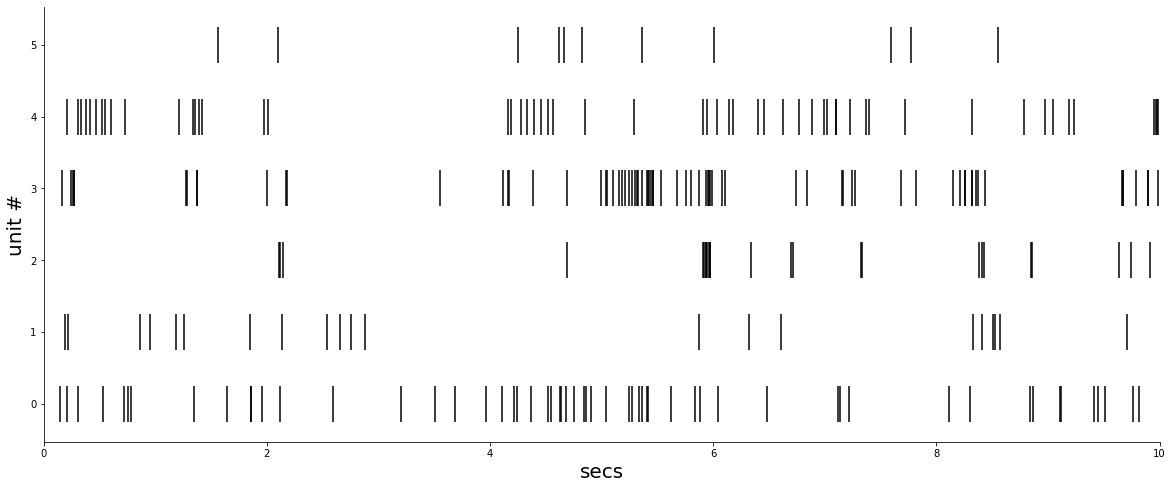

In [16]:
#spike rasters
fig, ax = plt.subplots(figsize=(20,8))
ax.fontsize = 20
for i,ind in enumerate(goodcells.index):
   plt.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25)
   plt.xlim(0, 10); plt.xlabel('secs',fontsize = 20); plt.ylabel('unit #',fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('spikeraster.pdf')



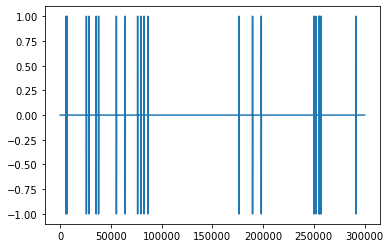

In [17]:
# generate wave file
spk =np.array(ephys_data.at[units[1],'spikeT'])

datarate = 30000
rate = 44100    # samples per second
Tmax = 10           # sample duration (seconds)
f = 440.0       # sound frequency (Hz)
# Compute waveform samples
t = np.linspace(0, Tmax, Tmax*datarate,endpoint=False)
x = np.zeros(np.size(t))
for spt in spk[spk<Tmax]:
    x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
    x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1
plt.plot(x)
    

# Write the samples to a file
wavio.write("spike.wav", x, datarate, sampwidth=1)


<xarray.DataArray 'timestamps' (frame: 68346)>
array([39819.33157125, 39819.34581675, 39819.36204725, ...,
       41087.95311275, 41087.96934325, 41087.98557375])
Coordinates:
  * frame       (frame) int64 0 1 2 3 4 5 ... 68341 68342 68343 68344 68345
    timestamps  (frame) float64 3.982e+04 3.982e+04 ... 4.109e+04 4.109e+04

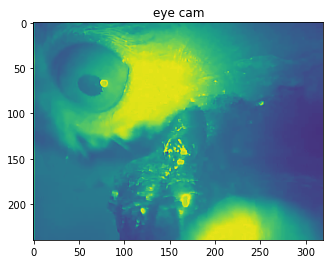

In [18]:
#load eye data
eye_data = xr.open_dataset(eye_file)
eye_vid = np.uint8(eye_data['REYE_video'])
plt.imshow(eye_vid[0,:,:]); plt.title('eye cam')
eyeT = eye_data.timestamps.copy()
eyeT

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


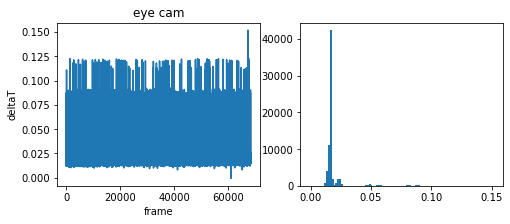

In [19]:
# plot eye timestamps
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].plot(np.diff(eyeT)); axs[0].set_xlabel('frame'); axs[0].set_ylabel('deltaT'); axs[0].set_title('eye cam')
axs[1].hist(np.diff(eyeT),100);

Text(0, 0.5, 'phi')

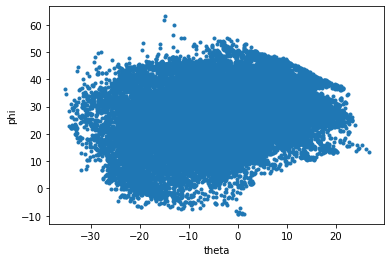

In [20]:
#plot eye postion across recording
eye_params = eye_data['REYE_ellipse_params']
plt.plot(eye_params.sel(ellipse_params = 'theta')*180/3.1415,eye_params.sel(ellipse_params = 'phi')*180/3.1415,'.')
plt.xlabel('theta'); plt.ylabel('phi')

In [21]:
# adjust eye/world/top times relative to ephys
eyeT = eye_data.timestamps  - ephysT0
if eyeT[0]<-600:
    eyeT = eyeT + 8*60*60 # 8hr offset for some data
worldT = world_data.timestamps - ephysT0
if worldT[0]<-600:
    worldT = worldT + 8*60*60
topT = top_data.timestamps - ephysT0
eyeT, worldT,topT

(<xarray.DataArray 'timestamps' (frame: 68346)>
 array([-3.20511750e-01, -3.06266250e-01, -2.90035750e-01, ...,
         1.26830103e+03,  1.26831726e+03,  1.26833349e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 68341 68342 68343 68344 68345
     timestamps  (frame) float64 3.982e+04 3.982e+04 ... 4.109e+04 4.109e+04,
 <xarray.DataArray 'timestamps' (frame: 68481)>
 array([-3.51081750e-01, -3.29264250e-01, -3.13065750e-01, ...,
         1.26827110e+03,  1.26828466e+03,  1.26830086e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 68476 68477 68478 68479 68480
     timestamps  (frame) float64 3.982e+04 3.982e+04 ... 4.109e+04 4.109e+04,
 <xarray.DataArray 'timestamps' (frame: 76059)>
 array([2.68672000e-01, 2.85222000e-01, 3.01837000e-01, ...,
        1.26828661e+03, 1.26830351e+03, 1.26831427e+03])
 Coordinates:
   * frame       (frame) int64 0 1 2 3 4 5 ... 76054 76055 76056 76057 76058
     timestamps  (frame) float64 3.982e+04 3.982e+04 ... 4.10

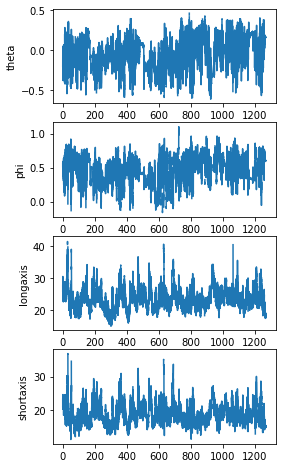

In [22]:
#plot eye variables
fig,axs = plt.subplots(4,1,figsize = (4,8))
for i,val in enumerate(eye_params.ellipse_params[0:4]):
    axs[i].plot(eyeT,eye_params.sel(ellipse_params = val))
    axs[i].set_ylabel(val.values)
    

In [235]:
# calculate eye veloctiy
dEye = np.diff(eye_params.sel(ellipse_params = 'theta'))*180/3.14159
eyeR = eye_params.sel(ellipse_params = 'longaxis').copy()
eye_vid.shape

(68346, 240, 320)

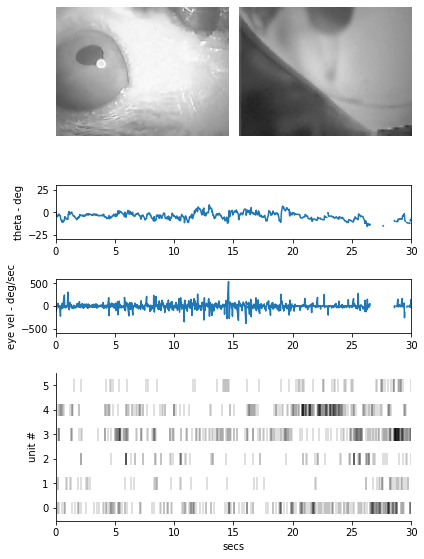

In [24]:
# plot data figure

fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(6,2)
axEye = fig.add_subplot(gs[0:2,0])
axWorld = fig.add_subplot(gs[0:2,1])
axTheta = fig.add_subplot(gs[2,:])
axdTheta = fig.add_subplot(gs[3,:])
axR = fig.add_subplot(gs[4:6,:])
#axRad = fig.add_subplot(gs[3,:])

tr = [0,30] # 340-385
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
axEye.set_xlim(40,200); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
   
#plot eye position
axTheta.cla()
axTheta.plot(eyeT,0.5*eye_params.sel(ellipse_params = 'theta')*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

# plot eye velocity
axdTheta.cla()
axdTheta.plot(eyeT[0:-1],dEye*60/2); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
axdTheta.set_xlim(tr[0],tr[1]); 
axdTheta.set_ylim(-10*60,10*60); axdTheta.set_ylabel('eye vel - deg/sec')

#axRad.cla()
#axRad.plot(eye_params.sel(ellipse_params = 'longaxis')[frameRange])
#axRad.set_xlim(0,frameRange[-1]-frameRange[0]); 
#axRad.set_ylabel('radius'); axRad.set_xlabel('frame #'); axRad.set_ylim(0,40)

# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.25)
axR.set_xlim(tr[0],tr[1]); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
axR.spines['right'].set_visible(False)
axR.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig('cams_eyes_spikes_092820_wn_0_30.pdf')

Text(0, 0.5, 'contrast')

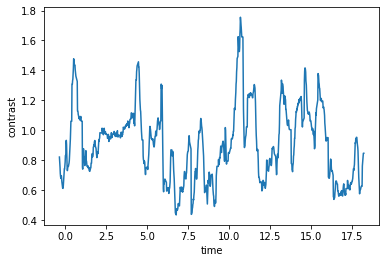

In [25]:
# normalize world movie and calculate contrast
img_norm = (world_vid-np.mean(world_vid,axis=0))/np.std(world_vid,axis=0)
contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:1000],contrast[0:1000])
plt.xlabel('time')
plt.ylabel('contrast')

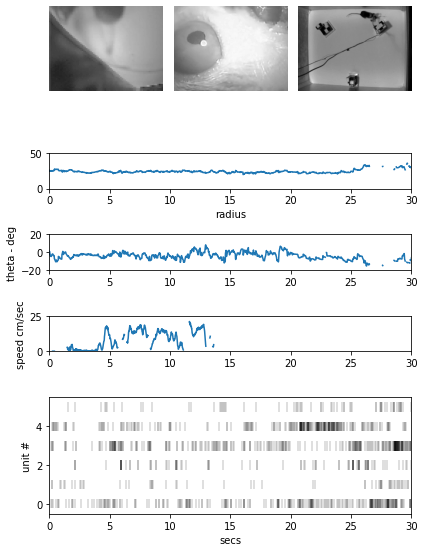

In [26]:
# plot another data figure (with contrast or speed)

fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(7,3)
axEye = fig.add_subplot(gs[0:2,1])
axWorld = fig.add_subplot(gs[0:2,0])
axTop = fig.add_subplot(gs[0:2,2])
axTheta = fig.add_subplot(gs[3,:])
axdTheta = fig.add_subplot(gs[4,:])
axVid = fig.add_subplot(gs[2,:])
axR = fig.add_subplot(gs[5:7,:])
#axRad = fig.add_subplot(gs[3,:])

tr = [0,30] # 340-385
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
axEye.set_xlim(40,200); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")

axTop.axis('off')
axTop.imshow(top_vid[0,:,:],'gray',vmin=0,vmax=255,aspect = 'equal')
   
#plot eye position
axTheta.cla()
axTheta.plot(eyeT,0.5*eye_params.sel(ellipse_params = 'theta')*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-20,20)

# grab bag plot -speed / eye vel

#speed
axdTheta.plot(topT[0:-1],spd); axdTheta.set_ylabel('speed cm/sec')
axdTheta.set_ylim([0, 25])

#eve velocity
#axdTheta.plot(eyeT[0:-1],dEye*60/2); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
#axdTheta.set_ylim(-10*60,10*60); axdTheta.set_ylabel('eye vel - deg/sec')

axdTheta.set_xlim(tr[0],tr[1]); 

#plot contrast or radius
#axVid.plot(worldT,contrast/2.5)
#axVid.set_ylim([0, 1.1]); axVid.set_ylabel('contrast')

axVid.plot(eyeT,0.5*(eye_params.sel(ellipse_params = 'longaxis') +eye_params.sel(ellipse_params = 'shortaxis')) )
axVid.set_xlabel('radius'); axVid.set_ylim([0, 50])
axVid.set_xlim(tr[0],tr[1]);



# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.25)
axR.set_xlim(tr[0],tr[1]); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
#axR.spines['right'].set_visible(False)
#axR.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig('cams_eyes_R_move_spikes_092820_wn_0_30.pdf')

In [27]:
# set up interpolators for eye and world videos
eyeInterp = interp1d(eyeT,eye_vid,axis=0)
worldInterp = interp1d(worldT,world_vid,axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:684: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


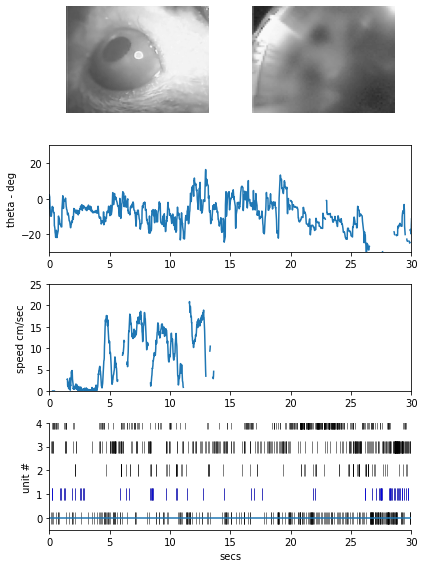

In [28]:
# make movie and sound

#unit to plot/record
this_unit = 1

#set up figure
fig = plt.figure(figsize = (6,8))
gs = fig.add_gridspec(4,2)
axEye = fig.add_subplot(gs[0,0])
axWorld = fig.add_subplot(gs[0,1])
axTheta = fig.add_subplot(gs[1,:])
axdTheta = fig.add_subplot(gs[2,:])
axR = fig.add_subplot(gs[3,:])
#axRad = fig.add_subplot(gs[3,:])

#timerange and center frame (only)
tr = [0, 30]
fr = np.mean(tr) # time for frame
eyeFr = np.abs(eyeT-fr).argmin(dim = "frame")
worldFr = np.abs(worldT-fr).argmin(dim = "frame")

axEye.cla(); axEye.axis('off'); 
axEye.imshow(eye_vid[eyeFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
#axEye.plot(eye_params.sel(ellipse_params = 'X0')[fr]/2,eye_params.sel(ellipse_params = 'Y0')[fr]/2,'r.')
axEye.set_xlim(40,200); axEye.set_ylim(0,120)

axWorld.cla();  axWorld.axis('off'); 
axWorld.imshow(world_vid[worldFr,:,:],'gray',vmin=0,vmax=255,aspect = "equal")
   
#plot eye position
axTheta.cla()
axTheta.plot(eyeT,eye_params.sel(ellipse_params = 'theta')*180/3.14159)
axTheta.set_xlim(tr[0],tr[1]); 
axTheta.set_ylabel('theta - deg'); axTheta.set_ylim(-30,30)

# plot eye velocity
axdTheta.cla()
#axdTheta.plot(eyeT[0:-1],dEye*60); ax.set_ylabel('dtheta')
#sacc = np.transpose(np.where(np.abs(dEye)>10))
#axdTheta.plot(sacc,np.sign(dEye[sacc])*20,'.')
#axdTheta.set_xlim(tr[0],tr[1]); 
#axdTheta.set_ylim(-23*60,30*60); axdTheta.set_ylabel('eye vel - deg/sec')

# plot speed
axdTheta.plot(topT[0:-1],spd); axdTheta.set_ylabel('speed cm/sec')
axdTheta.set_ylim([0, 25])
axdTheta.set_xlim(tr[0],tr[1]); 

#plot radius?
#axRad.cla()
#axRad.plot(eye_params.sel(ellipse_params = 'longaxis')[frameRange])
#axRad.set_xlim(0,frameRange[-1]-frameRange[0]); 
#axRad.set_ylabel('radius'); axRad.set_xlabel('frame #'); axRad.set_ylim(0,40)

# plot spikes
axR.fontsize = 20
for i,ind in enumerate(goodcells.index):
    axR.vlines(goodcells.at[ind,'spikeT'],i-0.25,i+0.25,'k',linewidth=0.5)
axR.vlines(goodcells.at[units[this_unit],'spikeT'],this_unit-0.25,this_unit+0.25,'b',linewidth=0.5)

axR.set_xlim(tr[0],tr[1]); axR.set_ylim(-0.5 , 4); axR.set_xlabel('secs'); axR.set_ylabel('unit #')
axR.spines['right'].set_visible(False)
axR.spines['top'].set_visible(False)

plt.tight_layout()

# now animate
writer = FFMpegWriter(fps=30)
with writer.saving(fig, "eye_world_spikes_092820_wn1_1.mp4", 100):
    for t in np.arange(tr[0],tr[1],1/30):
        
        # show eye and world frames
        axEye.cla(); axEye.axis('off'); 
        axEye.imshow(eyeInterp(t),'gray',vmin=0,vmax=255,aspect = "equal")
        axEye.set_xlim(0,160); axEye.set_ylim(0,120)
        
        axWorld.cla(); axWorld.axis('off'); 
        axWorld.imshow(np.flipud(worldInterp(t)),'gray',vmin=0,vmax=255,aspect = "equal")
        
        #plot line for time, then remove
        ln = axR.vlines(t,-0.5,30,'b')
        writer.grab_frame()
        ln.remove()
        
###



# generate wave file
sp =np.array(ephys_data.at[units[this_unit],'spikeT'])-tr[0]
sp = sp[sp>0]
datarate = 30000
f = 440.0       # sound frequency (Hz)
# Compute waveform samples
tmax = tr[1]-tr[0]
t = np.linspace(0, tr[1]-tr[0], (tr[1]-tr[0])*datarate,endpoint=False)
x = np.zeros(np.size(t))
for spt in sp[sp<tmax]:
    x[np.int64(spt*datarate) : np.int64(spt*datarate +30)] = 1
    x[np.int64(spt*datarate)+31 : np.int64(spt*datarate +60)] =- 1
plt.plot(x)
    

# Write the samples to a file
wavio.write("wn_spike1.wav", x, datarate, sampwidth=1)

In [29]:
#https://cloudconvert.com/wav-to-mp3
# https://www.kapwing.com/tools/add-music-to-video

In [30]:
# normalize world video
im_std = np.std(world_vid,axis=0)
im_std = 32;
img_norm = (world_vid-np.mean(world_vid,axis=0))/im_std
#plt.imshow(im_std)
#plt.colorbar()

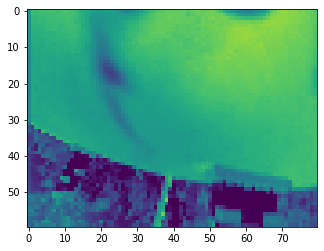

In [31]:
plt.imshow(img_norm[0,:,:],vmin=-2,vmax=2)

Text(0, 0.5, 'contrast')

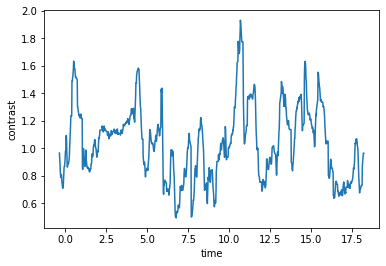

In [32]:
#calculate image contrast
contrast = np.empty(worldT.size)
for i in range(worldT.size):
    contrast[i] = np.std(img_norm[i,:,:])
plt.plot(worldT[0:1000],contrast[0:1000])
plt.xlabel('time')
plt.ylabel('contrast')


In [158]:
#set up timebase for subsequent analysis
dt = 0.1
t = np.arange(0, np.max(worldT),dt)

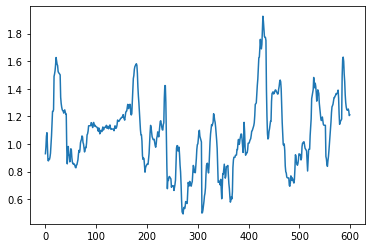

In [34]:
# interpolate and plot contrast
newc =interp1d(worldT,contrast)
contrast_interp = newc(t[0:-1])
contrast_interp.shape
plt.plot(contrast_interp[0:600])

In [216]:
# calculate firing rate at new timebase
ephys_data['rate'] = nan
ephys_data['rate'] = ephys_data['rate'].astype(object)
for i,ind in enumerate(ephys_data.index):
    ephys_data.at[ind,'rate'],bins = np.histogram(ephys_data.at[ind,'spikeT'],t                                             )
ephys_data['rate']= ephys_data['rate']/dt
goodcells = ephys_data.loc[ephys_data['group']=='good']
goodcells

,Amplitude,ContamPct,KSLabel,amp,ch,depth,fr,group,n_spikes,sh,waveform,spikeT,t0,rate
0,392.0,19.8,mua,27.890654,0,1,6.634466,good,12812,0,"[0.0033347560000000004, 0.0074715107000000005,...","[0.1515, 0.21030000000000001, 0.3078, 0.5303, ...",39819.652083,"[0.0, 10.0, 10.0, 10.0, 0.0, 10.0, 0.0, 30.0, ..."
6,397.2,8.8,good,25.888235,2,3,3.971773,good,7670,0,"[0.0074969623, 0.0077951048, 0.0082895886, 0.0...","[0.1880666667, 0.2228, 0.8604, 0.9527333333, 1...",39819.652083,"[0.0, 10.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10...."
27,370.5,13.6,mua,25.447294,9,10,1.696936,good,3277,0,"[0.0070176478, 0.0094096577, 0.007719868800000...","[2.1128, 2.1213666667, 2.1483333333, 4.6925, 5...",39819.652083,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
36,738.5,9.9,good,33.524639,12,13,5.643335,good,10898,0,"[-0.0004038787, 0.0022035816000000002, -0.0014...","[0.16266666670000002, 0.2492, 0.2598666667, 0....",39819.652083,"[0.0, 10.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
39,662.7,25.5,mua,29.932041,13,14,5.049900,good,9752,0,"[0.0111215748, -0.0012248545, -0.0010454387000...","[0.2086666667, 0.3113666667, 0.337400000000000...",39819.652083,"[0.0, 0.0, 10.0, 30.0, 20.0, 20.0, 10.0, 10.0,..."
56,572.8,30.7,mua,29.767956,12,13,2.967179,good,5730,0,"[0.014073474300000001, -0.0021080885, 1.675690...","[1.566, 2.104, 4.2505333333, 4.6178333333, 4.6...",39819.652083,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


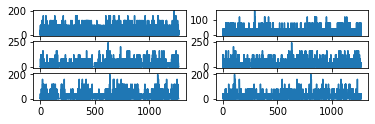

In [36]:
# plot firing rates
for i, ind in enumerate(goodcells.index):
    plt.subplot(7,2,i+1)
    plt.plot(t[0:-1],goodcells.at[ind,'rate'])

ValueError: x and y must have same first dimension, but have shapes (50732,) and (12683,)

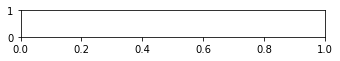

In [213]:
#scatter of contrast vs rate
plt.figure(figsize = (12,4))
for i, ind in enumerate(goodcells.index):
    plt.subplot(7,2,i+1)
    plt.plot(contrast_interp,goodcells.at[ind,'rate'],'.')
plt.xlabel('contrast')
plt.ylabel('rate')

In [214]:
# calculate contrast - response functions
# mean firing rate in timebins correponding to contrast ranges
resp = np.empty((6,20))
crange = np.arange(0,2,0.1)
for i,ind in enumerate(goodcells.index):
    for c,cont in enumerate(crange):
        resp[i,c] = np.mean(goodcells.at[ind,'rate'][(contrast_interp>cont) & (contrast_interp<(cont+0.1))])
plt.plot(crange,np.transpose(resp))
#plt.ylim(0,10)
plt.xlabel('contrast')
plt.ylabel('sp/sec')
    

IndexError: boolean index did not match indexed array along dimension 0; dimension is 12683 but corresponding boolean dimension is 50732

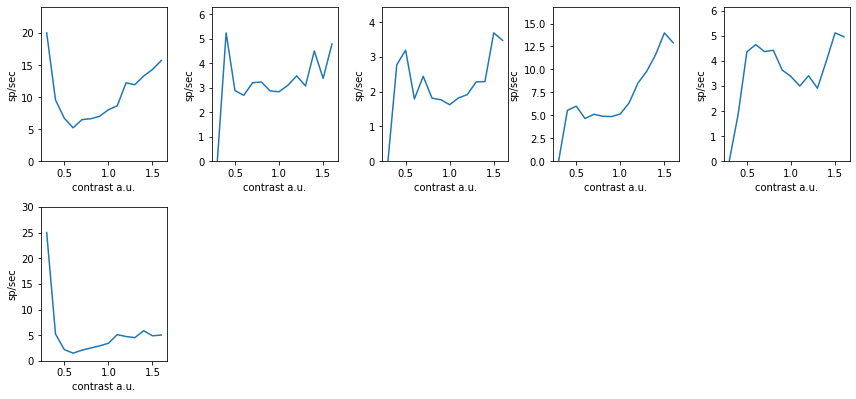

In [39]:
# plot individual contrast response functions in subplots
fig = plt.figure(figsize = (12,8))
for i, ind in enumerate(goodcells.index):
    plt.subplot(3,5,i+1)
    plt.plot(crange[2:-3],resp[i,2:-3])
    plt.ylim([0 , max(resp[i,3:-3])*1.2])
    plt.xlabel('contrast a.u.'); plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig('contrast_resp_101520_fm1_merge.pdf')

In [40]:
# create interpolator for movie data so we can evaluate at same timebins are firing rate
movInterp = interp1d(worldT,img_norm,axis=0)

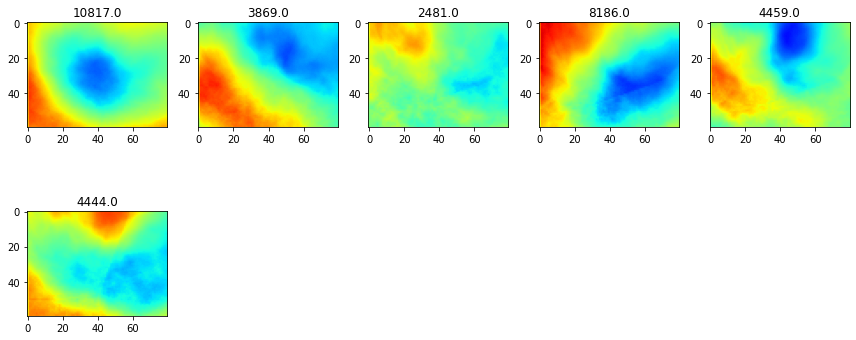

In [41]:
# calculate spike-triggered average
sta = 0
lag = -0.1
plt.figure(figsize = (12,8))
for c, ind in enumerate(goodcells.index):
    sta =0
    totalR = 0;
    r = goodcells.at[ind,'rate']
    for i in range(np.uint(t.size*0)+1000,np.uint(t.size*1)-1000):
        sta = sta+r[i]*(movInterp(t[i]-lag))
        totalR = totalR + r[i]
    plt.subplot(3,5,c+1)
    sta = sta/totalR
    #sta[abs(sta)<0.1]=0
    plt.imshow((sta - np.mean(sta)),vmin=-0.5,vmax=0.5,cmap = 'jet')
    plt.title(totalR*dt)
plt.tight_layout()
plt.savefig('sta_101520_vm045_fm_merge.pdf')


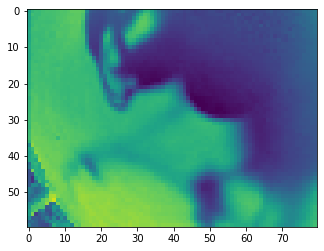

In [42]:
plt.imshow(movInterp(100),vmin = -2, vmax = 2)

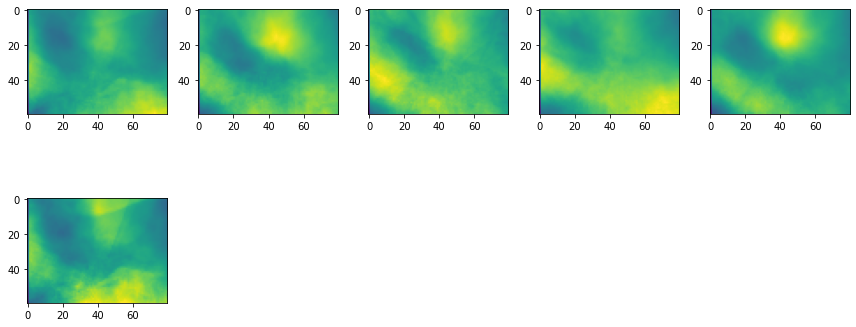

In [43]:
# calculate spike-triggered variance
sta = 0
lag = 0.075
plt.figure(figsize = (12,8))
for c, ind in enumerate(goodcells.index):
    sta = 0
    r = goodcells.at[ind,'rate']
    for i in range(5,t.size-10):
        sta = sta+r[i]*(movInterp(t[i]-lag))**2
    plt.subplot(3,5,c+1)
    sta = sta/np.sum(r)
    plt.imshow(sta)
plt.tight_layout()

<ipython-input-229-9c2a4ed0bcad>:5: RuntimeWarning: invalid value encountered in greater
  upsacc = eyeT[np.append(dEye,0)>sthresh].copy()
<ipython-input-229-9c2a4ed0bcad>:7: RuntimeWarning: invalid value encountered in less
  downsacc= eyeT[np.append(dEye,0)<-sthresh].copy()


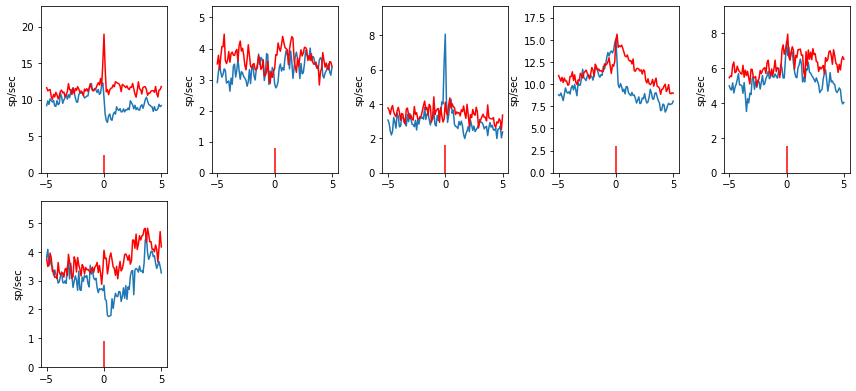

In [229]:
# calculate saccade-locked psth
fig = plt.figure(figsize = (12,8))
trange = np.arange(-5,5.1,0.1)
sthresh = 5;
upsacc = eyeT[np.append(dEye,0)>sthresh].copy()
upsacc = upsacc[upsacc>5]  # buffer at beginning
downsacc= eyeT[np.append(dEye,0)<-sthresh].copy()
downsacc = downsacc[downsacc>5] #buffer at beginning
upsacc_avg = np.zeros((units.size,trange.size))
downsacc_avg = np.zeros((units.size,trange.size))
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    for s in upsacc:
        upsacc_avg[i,:] = upsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/upsacc.size
    for s in downsacc:
        downsacc_avg[i,:]= downsacc_avg[i,:]+ rateInterp(np.array(s)+trange)/upsacc.size
    plt.subplot(3,5,i+1)
    plt.plot(trange,upsacc_avg[i,:])
    plt.plot(trange,downsacc_avg[i,:],'r')
    plt.vlines(0,0,np.max(upsacc_avg[i,:]*0.2),'r')
    plt.ylim([0, np.max(np.concatenate((upsacc_avg[i,:],downsacc_avg[i,:]),axis = None))*1.2])
    plt.ylabel('sp/sec')
plt.tight_layout()
plt.savefig('saccade_101520_fm1_merge.pdf')
        


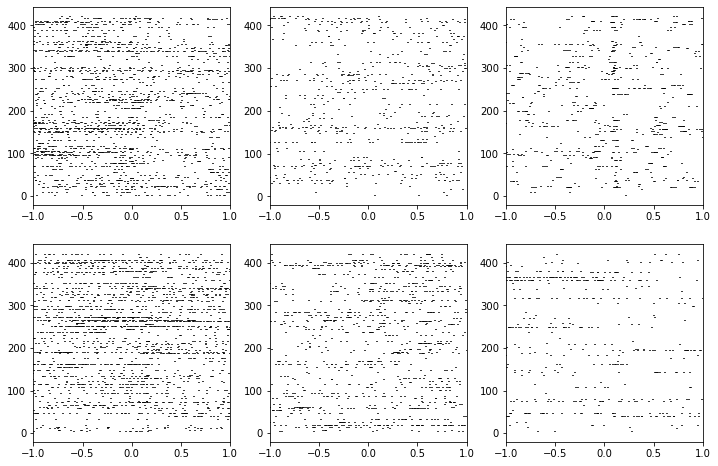

In [209]:
fig = plt.figure(figsize = (12,8))
ns = np.zeros((6,len(upsacc)+1))
for i, ind in enumerate(goodcells.index):
    sp = np.array(goodcells.at[units[i],'spikeT'])*spike_corr
    plt.subplot(2,3,i+1)
    n = 0
    for s in upsacc:
        n= n+1
        sd = np.abs(sp-np.array(s))<1
        sacc_sp = sp[sd]
        ns[i,n] =len(sacc_sp)
        plt.vlines(sacc_sp-np.array(s),n-0.25,n+0.25)
    plt.xlim(-1,1)
   # plt.ylim(0,25)
plt.savefig('saccade_upraster_101520_fm1_merge.pdf')

In [226]:
np.max(t)

1268.3000000000002

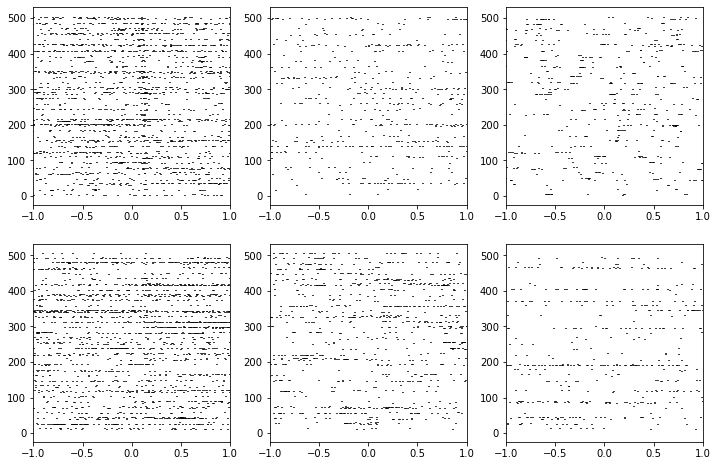

In [208]:
fig = plt.figure(figsize = (12,8))
for i, ind in enumerate(goodcells.index):
    sp = np.array(goodcells.at[units[i],'spikeT'])*spike_corr
    plt.subplot(2,3,i+1)
    n = 0
    for s in downsacc:
        n= n+1
        sd = np.abs(sp-np.array(s))<10
        sacc_sp = sp[sd]
        plt.vlines(sacc_sp-np.array(s),n-0.25,n+0.25)
    plt.xlim(-1,1)

<ipython-input-179-60531a7f049f>:16: RuntimeWarning: invalid value encountered in greater
  usePts =(useSpd>sp_range[j]) & (useSpd<sp_range[j+1])
<ipython-input-179-60531a7f049f>:16: RuntimeWarning: invalid value encountered in less
  usePts =(useSpd>sp_range[j]) & (useSpd<sp_range[j+1])


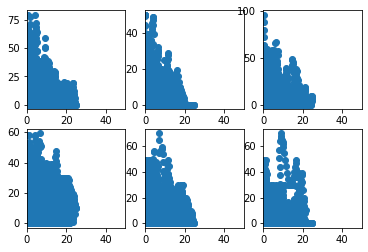

In [179]:
n_units = len(goodcells)
sp_range = np.arange(0,25,2)
spT = topT[0:-1].copy()
useSpT = spT[spT<t[-2]].copy()
useSpd = spd[spT<t[-2]].copy()
sp_scatter = np.zeros((n_units,len(useSpd)))
sp_tuning = np.zeros((n_units,len(sp_range)-1))
sp_tuning_err = sp_tuning.copy()
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    sp_scatter[i,:] = rateInterp(useSpT)
    plt.subplot(2,3,i+1)
    plt.scatter(useSpd,sp_scatter[i,:])
    plt.xlim([0, 50])
    for j in range(len(sp_range)-1):
        usePts =(useSpd>sp_range[j]) & (useSpd<sp_range[j+1])
        sp_tuning[i,j] = np.mean(sp_scatter[i,usePts])
        sp_tuning_err[i,j] = np.std(sp_scatter[i,usePts])/np.sqrt(np.count_nonzero(usePts))

(array([[1.1218e+04, 4.8790e+03, 5.2300e+03, 1.7590e+03, 8.0300e+02,
         3.7200e+02, 1.1300e+02, 9.4000e+01, 1.3000e+01, 1.5000e+01],
        [1.7010e+03, 5.8300e+02, 5.1500e+02, 2.4200e+02, 1.5400e+02,
         6.5000e+01, 3.6000e+01, 2.1000e+01, 6.0000e+00, 1.0000e+00],
        [7.7800e+02, 2.6300e+02, 2.0300e+02, 1.1000e+02, 3.1000e+01,
         2.7000e+01, 1.3000e+01, 1.2000e+01, 8.0000e+00, 9.0000e+00],
        [5.7300e+02, 1.7600e+02, 1.4800e+02, 5.4000e+01, 4.3000e+01,
         1.9000e+01, 1.4000e+01, 9.0000e+00, 6.0000e+00, 5.0000e+00],
        [5.2300e+02, 1.3700e+02, 1.2000e+02, 7.2000e+01, 3.7000e+01,
         3.2000e+01, 1.1000e+01, 1.1000e+01, 4.0000e+00, 1.0000e+00],
        [4.2400e+02, 1.2900e+02, 1.2700e+02, 4.9000e+01, 1.6000e+01,
         1.7000e+01, 9.0000e+00, 1.2000e+01, 0.0000e+00, 2.0000e+00],
        [3.7100e+02, 9.7000e+01, 8.8000e+01, 4.7000e+01, 1.8000e+01,
         1.5000e+01, 7.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00],
        [3.5800e+02, 8.1000

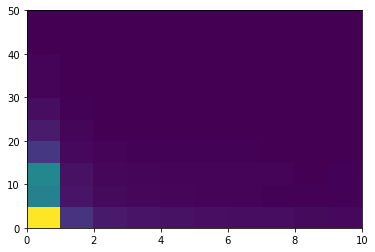

In [233]:
plt.hist2d(useSpd,sp_scatter[0,:].T,range = [[0,10],[0,50]])

In [196]:
usePts =(useSpd>sp_range[j]) & (useSpd<sp_range[j+1])
sp_tuning[i,j] = np.mean(sp_scatter[i,usePts])
sp_tuning_err[i,j] = np.std(sp_scatter[i,usePts])/np.sqrt(np.count_nonzero(usePts))

<ipython-input-196-de3530f9e391>:1: RuntimeWarning: invalid value encountered in greater
  usePts =(useSpd>sp_range[j]) & (useSpd<sp_range[j+1])
<ipython-input-196-de3530f9e391>:1: RuntimeWarning: invalid value encountered in less
  usePts =(useSpd>sp_range[j]) & (useSpd<sp_range[j+1])


In [200]:
sp_scatter[i,usePts]

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    , 16.4262, 18.1171, 19.8784,
       17.1174, 13.7844, 10.3616,  7.1104,  3.7568, 12.3416, 25.6536,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    , 10.    , 10.    ,
       10.    , 10.    , 10.    ,  9.5059,  7.8765,  6.2023,  4.4883,
        2.8269,  1.1232,  0.    ,  0.    ,  0.    ])

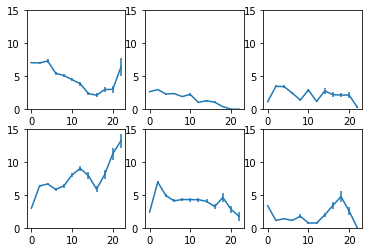

In [189]:
for i in range(n_units):
    plt.subplot(2,3,i+1)
    plt.errorbar(sp_range[:-1],sp_tuning[i,:],yerr=sp_tuning_err[i,:])
    plt.ylim(0,15)

(0.0, 100.0)

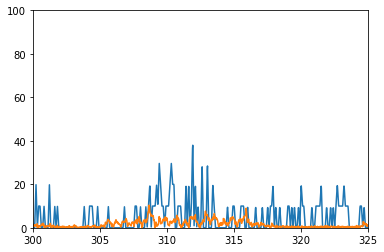

In [174]:
plt.plot(useSpT,sp_scatter[0,:])
plt.plot(useSpT, useSpd*5)
plt.xlim([300, 325])
plt.ylim([0, 100])

In [175]:
dt

0.1

(0.0, 20.0)

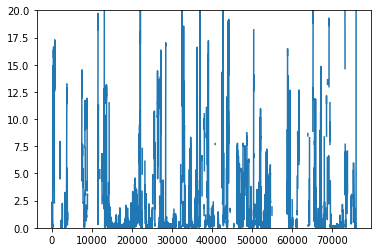

In [151]:
plt.plot(spd)
plt.ylim(0,20)

(0.0, 60.0)

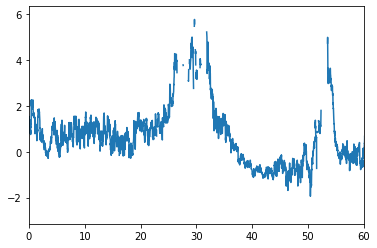

In [238]:
Rnorm = (eyeR - np.mean(eyeR))/np.std(eyeR)
plt.plot(eyeT,Rnorm)
plt.xlim([0,60])


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


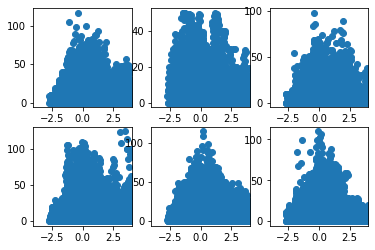

In [246]:
n_units = len(goodcells)
R_range = np.arange(-4,4,0.5)
useEyeT = eyeT[(eyeT<t[-2]) & (eyeT>t[0])].copy()
useR = Rnorm[(eyeT<t[-2]) & (eyeT>t[0])].copy()
R_scatter = np.zeros((n_units,len(useR)))
R_tuning = np.zeros((n_units,len(R_range)-1))
R_tuning_err =R_tuning.copy()
for i, ind in enumerate(goodcells.index):
    rateInterp = interp1d(t[0:-1],goodcells.at[ind,'rate'])
    R_scatter[i,:] = rateInterp(useEyeT)
    plt.subplot(2,3,i+1)
    plt.scatter(useR,R_scatter[i,:])
    plt.xlim([-4,4])
    for j in range(len(R_range)-1):
        usePts =(useR>R_range[j]) & (useR<R_range[j+1])
        R_tuning[i,j] = np.mean(R_scatter[i,usePts])
        R_tuning_err[i,j] = np.std(R_scatter[i,usePts])/np.sqrt(np.count_nonzero(usePts))

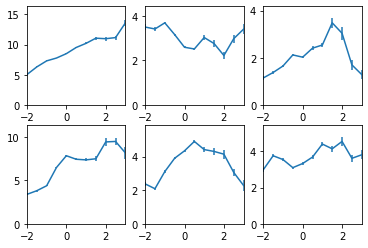

In [252]:
for i in range(n_units):
    plt.subplot(2,3,i+1)
    plt.errorbar(R_range[:-1],R_tuning[i,:],yerr=R_tuning_err[i,:])
    plt.ylim(0,np.nanmax(R_tuning[i,:]*1.2))
    plt.xlim([-2, 3])

In [245]:
R_range

array([-4.  , -3.75, -3.5 , -3.25, -3.  , -2.75, -2.5 , -2.25, -2.  ,
       -1.75, -1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,
        0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,  2.5 ,
        2.75,  3.  ,  3.25,  3.5 ,  3.75])